# 6sense: Predicting Consumer Purchases

## Introduction-

The task for this assignment is to predict whether or not customers will make a purchase based on their previous activities. 

---

## Setup-

In [21]:
# Load the required libraries
import os
import csv
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# Set the working directory
os.chdir('/Users/zansadiq/Documents/Work/takehome')

In [23]:
# Open the files
training = pd.read_csv('training.tsv', sep = '\t', header = None, names = ('user_id', 'activity_date', 'activity_type'))

testing = pd.read_csv('test.tsv', sep = '\t', header = None, names = ('user_id', 'activity_date', 'activity_type'))

In [24]:
# Fix the dates
training['activity_date'] = pd.to_datetime(training['activity_date'])

testing['activity_date'] = pd.to_datetime(testing['activity_date'])

In [25]:
# Convert activities to factor 
training['activity_type'] = training['activity_type'].astype('category')

testing['activity_type'] = testing['activity_type'].astype('category')

---

## Feature Engineering-

Before we can feed our data into a model, we must first create some new features and modify the existing variables so that they are all in a suitable format for the algorithms.

In [26]:
# Create dummy variables for activity types
dummies = pd.get_dummies(training, columns = ['activity_type'], drop_first = True)

test_dummies = pd.get_dummies(testing, columns = ['activity_type'], drop_first = True)

In [27]:
# Fill missing columns in test data
test_dummies = test_dummies.assign(activity_type_EmailClickThrough = 0, activity_type_Purchase = 0)

In [28]:
# List all of the column headers
dat_vars = dummies.columns.values.tolist()
test_vars = test_dummies.columns.values.tolist() 

# Select the dependent variable
y = ['activity_type_Purchase']

# Select independent variables
x = [i for i in dat_vars if i not in ['user_id', 'activity_type_Purchase', 'activity_date']]
x_test = [i for i in test_vars if i not in ['user_id', 'activity_type_Purchase', 'activity_date']]

# Fill the values
x = dummies[x]
y = dummies['activity_type_Purchase']

x_test = test_dummies[x_test]
y_test = test_dummies['activity_type_Purchase']

# Split the training data for training and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 100)

---

## Modeling-

Now that we have modified our data, we can go ahead and feed it into a model. Lets perform a logistic regression. 

### Logistic Regression:

In [29]:
# Logistic Regression
log_reg = LogisticRegression()

log_reg.fit(x_train, y_train)

# Predictions
train_preds = log_reg.predict(x_train)
val_preds = log_reg.predict(x_val)
test_preds = log_reg.predict(x_test)

# Print results
print(accuracy_score(y_val, log_reg.predict(x_val)))

0.978873058083334


Our model achieved a ~98% accuracy on predicting purchases for the validation set. This is pretty good. 

Logistic regression assigns class labels based on the predicted probability, we will enhance our overall model by considering these probabilities in addition the actual outcome.

In [30]:
# Examine the probabilities
train_probs = log_reg.predict_proba(x_train)
val_probs = log_reg.predict_proba(x_val)
test_probs = log_reg.predict_proba(x_test)

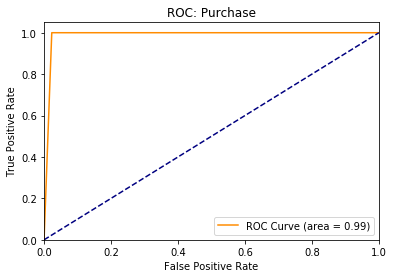

In [31]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_train, train_preds)
roc_auc= auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', label = 'ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Purchase')
plt.legend(loc="lower right")
plt.show()

From the ROC curve, what we can see is that it is not really insightful to try and select a custom probability threshold. We will leave the default value.

In [32]:
# Combine probabilities with test set
test_dummies['activity_type_Purchase'] = test_preds
test_dummies['prob_no_purchase'] = test_probs[:,0]
test_dummies['prob_purchase'] = test_probs[:,1]

---

## Conclusion-

In [33]:
# Sort probabilities and select top 1000
sort = test_dummies.sort_values(['prob_purchase'], ascending = [False])

out = sort.head(n = 1000)

We have selected the top 1000 users from the test set that are most likely to make a purchase. However, the more important question is- what features or characteristics went into developing this prediction? 

In order to find out, we shall have to look at the importance of the variables that went into the Logistic Regression model. Lets go ahead and take a look at the top 3 features.

In [34]:
# Variable importance
coefs = log_reg.coef_[0]

# Select top variables
top_three = np.argpartition(coefs, -4)[-4:]

# Output
print(test_dummies.columns[top_three])

Index(['activity_type_PageView', 'activity_type_EmailOpen',
       'activity_type_FormSubmit', 'user_id'],
      dtype='object')


From our output, we can see that the top three activities indicating that a purchase is likely are: page views, reading emails, and submitting forms. 

Finally, we can store our predictions in the form of a `.csv` file for later reference.

In [35]:
# Write results to csv
out.to_csv('purchase_predictions.csv', sep='\t')